# Day 12 - Cellular automata

It's a 1D [cellular automata](https://en.wikipedia.org/wiki/Cellular_automaton); like Conway's Game of Life but on a line rather than on a grid. This is a [next-nearest-neighbor system](https://qlfiles.net/the-ql-files/next-nearest-neighbors-cellular-automata/).

We could use numpy again, but since this is an infinite grid, I thought I'd give a linked list a try. The linked list is centered on coordinate 0, then fans out in either direction. Running a step then replaces old state with new, passing old state out to either side to update the next nodes.

To ensure performance and unlimited depth, I do want to avoid recursion here.

In [1]:
import re

from dataclasses import dataclass, field
from collections import deque
from itertools import chain, islice, product, repeat, tee
from operator import attrgetter
from typing import Callable, Dict, Iterator, Iterable, Mapping, List, Optional, Tuple

Dir = str
Plant = bool
_NextFunc = Callable[['Pot'], 'Pot']
_next_map: Mapping[str, _NextFunc] = {d: attrgetter(d) for d in ('left', 'right')}

@dataclass
class Pot:
    __slots__ = ('id', 'plant', 'left', 'right')

    plant: Plant

    def __post_init__(self) -> None:
        self.left: Optional[Pot] = None
        self.right: Optional[Pot] = None

    def iter_dir(self, dir: Dir) -> Iterator['Pot']:
        """Iterate over the chain in the given direction
        
        The current pot is *not* included.
        
        """
        next_ = _next_map[dir]
        p = next_(self)
        while p:
            yield p
            p = next_(p)
    
    def with_potentials(self, dir: Dir) -> Iterator['Pot']:
        """Same as iter_dir but with PotentialPot added at the end"""
        p = self
        for p in self.iter_dir(dir):
            yield p
        potpot = PotentialPot(False, p, dir)
        yield potpot
        yield from potpot.with_potentials(dir)
        
    def __str__(self) -> str:
        return '#' if self.plant else '.'

    def append(self, dir: Dir, pot: 'Pot') -> 'Pot':
        assert getattr(self, dir) is None
        setattr(self, dir, pot)
        setattr(pot, _reverse[dir], self)
        return pot
    
    def detach(self, dir: Dir) -> 'Pot':
        assert getattr(self, dir) is not None
        next_ = getattr(self, dir)
        setattr(self, dir, None)
        setattr(next_, _reverse[dir], None)
        return next_
            
    @classmethod
    def from_initial(cls, initial: str) -> Tuple['Pot', int]:
        """Create pots from initail .# string
        
        Returns head of new chain and length
        """
        # empty node to attach root and rest of chain to
        start = pot = cls(False)
        for l, c in enumerate(initial):
            pot = pot.append('right', cls(c == '#'))
        root, root.left = start.right, None
        return root, l + 1

@dataclass
class PotentialPot(Pot):
    """Pot that is not yet linked into the chain
    
    When .plant is set to True, will become a permanent linked pot.
    
    """
    parent: Pot
    dir: Dir
    
    def __post_init__(self):
        super().__post_init__()
        self._linked: Optional[Pot] = None
        # make it easy to go back
        setattr(self, _reverse[self.dir], self.parent)

    @property
    def plant(self) -> Plant:
        if self._linked:
            return self._linked.plant
        return False
    
    @plant.setter
    def plant(self, plant: Plant) -> None:
        if not hasattr(self, '_linked'):
            # initialising, just ignore this one
            return
        if self._linked:
            self._linked.plant = plant
        elif plant:
            # link in new node; determine new id first
            self._linked = type(self.parent)(plant)
            self.parent.append(self.dir, self._linked)
    
    def with_potentials(self, dir: Dir) -> Iterator['Pot']:
        if self._linked:
            yield from self._linked.with_potentials(dir)

_rule_parse = re.compile('[.#]').findall
_State = List[Plant]
_reverse: Mapping[Dir, Dir] = {'left': 'right', 'right': 'left'}
_for_d: Iterable[Tuple[Dir, Callable[[str, _State], _State]]] = (
    # direction and state rotation function
    # s[:4] and s[-4:] make it possible to use 
    # the rotation functions to grow the central state too
    ('left', (lambda s, p: [p, *s[:4]])),
    ('right', (lambda s, p: [*s[-4:], p])),
)   

_RuleKey = Tuple[Plant, Plant, Plant, Plant, Plant]
_blank_rules: Mapping[_RuleKey, Plant] = dict.fromkeys(product([False, True], repeat=5), False)
        
@dataclass
class Rules:
    mapping: Dict[_RuleKey, Plant]

    @classmethod
    def from_lines(cls, lines: Iterable[str]) -> 'Rules':
        parsed = ((c == '#' for c in _rule_parse(line)) for line in lines if line.strip())
        return cls({**_blank_rules, **{tuple(k): r for *k, r in parsed}})
    
    def __str__(self) -> str:
        lines = []
        for k, p in self.mapping.items():
            *ks, ps = map('.#'.__getitem__, [*k, p])
            lines.append(f"{''.join(ks)} => {ps}")
        return '\n'.join(lines)
    
    def apply(self, root: Pot) -> Tuple[int, int]:
        """Apply rules to pots to produce an updated sequence
        
        Returns new length and summed pot ids for pots with plants
        """
        next_plant_state = self.mapping.__getitem__
        lengths = {'left': 0, 'right': 0}

        # build state map for central location, and lookahead iterators
        state: List[Plant] = [root.plant]
        lookaheads = {}
        for dir, rot in _for_d:
            lookahead = chain(
                (p.plant for p in root.iter_dir(dir)),
                repeat(False)
            )
            for plant in islice(lookahead, None, 2):
                state = rot(state, plant)
            lookaheads[dir] = lookahead
        central_state = state
            
        # update the root value
        root.plant = next_plant_state(tuple(state))
        first = 0 if root.plant else None

        # then go either direction
        for dir, rot in _for_d:
            lookahead = lookaheads[dir]            
            state = central_state
            pot = root
            for pot, nextplant in zip(pot.with_potentials(dir), lookahead):
                lengths[dir] += 1

                # update state with plant from 2 pots down
                state = rot(state, nextplant)

                # update this state
                pot.plant = next_plant_state(tuple(state))
                
                if pot.plant and (first is None or (dir == 'left' and first > -lengths['left'])):
                    first = -lengths[dir] if dir == 'left' else lengths[dir]
        
            # trim back down to last True value
            rev = _reverse[dir]
            assert isinstance(pot, PotentialPot)
            pot = pot.parent
            lengths[dir] -= 1
            while not pot.plant and pot is not root:
                lengths[dir] -= 1
                pot = pot.detach(rev)
        
        return lengths['left'], first, lengths['right'] + lengths['left'] + 1

@dataclass
class Plants:
    root: Pot
    length: int
    rules: Rules

    def __post_init__(self):
        self.left_length: int = 0
        self.first_id: int = 0
        if not self.root.plant:
            self.first_id = next(
                (i for i, p in enumerate(self.root.iter_dir('right')) if p.plant),
                0   # empty board has no correct value here
            )

    @classmethod
    def from_lines(cls, lines: Iterable[str]) -> 'Plants':
        it = iter(lines)
        initial = next(it).partition('initial state:')[-1].strip()
        return cls(*Pot.from_initial(initial), Rules.from_lines(it))
    
    def __len__(self) -> int:
        return self.length

    def __str__(self) -> str:
        root = self.root
        chars = [str(root), *map(str, root.iter_dir('left'))][::-1]
        chars += map(str, root.iter_dir('right'))
        return ''.join(chars)

    def step(self) -> int:
        self.left_length, self.first_id, self.length = self.rules.apply(self.root)
    
    @property
    def score(self) -> int:
        return (
            sum(i for i, p in enumerate(self.root.iter_dir('right'), 1) if p.plant) -
            sum(i for i, p in enumerate(self.root.iter_dir('left'), 1) if p.plant)
        )


In [2]:
testlines = '''\
initial state: #..#.#..##......###...###

...## => #
..#.. => #
.#... => #
.#.#. => #
.#.## => #
.##.. => #
.#### => #
#.#.# => #
#.### => #
##.#. => #
##.## => #
###.. => #
###.# => #
####. => #'''.splitlines()
testplants = Plants.from_lines(testlines)
for _ in range(20):
    testplants.step()
assert testplants.score == 325

In [3]:
import aocd

data = aocd.get_data(day=12, year=2018)

In [4]:
plants = Plants.from_lines(data.splitlines())
for _ in range(20):
    plants.step()
print('Part 1:', plants.score)

Part 1: 3725


## Part 2, turning the knob to 11

Clearly, we can't run this code 50 billion steps and hope to get an answer soon. There must be a shortcut.

So we need to look for cycles or a stable state that we can then extrapolate from. Any given stable state can be converted to a score if we know at which pot id that state will appear at iteration 50 billion. Now, there are next-nearest-neighbour rule systems that are totally chaotic, but we'll just have to trust that the AoC organisers knew what they were doing when providing the puzzle input.

And indeed, within 100 steps, the pattern stabalises and only keeps moving to the right:

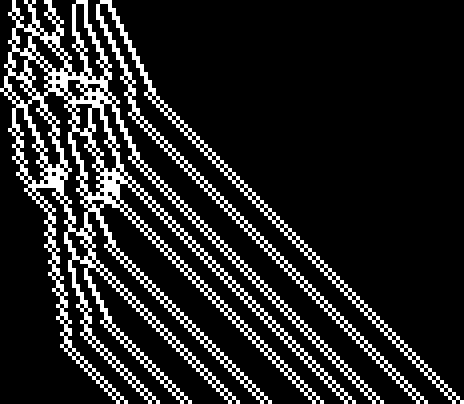

In [5]:
from PIL import Image

def visualise(plants, steps, scale=1):
    states = [(plants.left_length, str(plants))]
    for _ in range(steps):
        plants.step()
        states.append((plants.left_length, str(plants)))
    
    width_left = max(ll for ll, s in states)
    width = max(len(s) + (width_left - ll) for ll, s in states)
    img = Image.new('1', (width, steps + 1), None)
    img.putdata([
        p
        for ll, s in states
        for p in chain(
            [0] * (width_left - ll),
            (255 if c == '#' else 0 for c in s),
            [0] * (width - len(s) - (width_left - ll))
        )
    ])
    if scale != 1:
        img = img.resize((img.width * scale, img.height * scale))
    return img

visualise(Plants.from_lines(testlines), 100, 4)

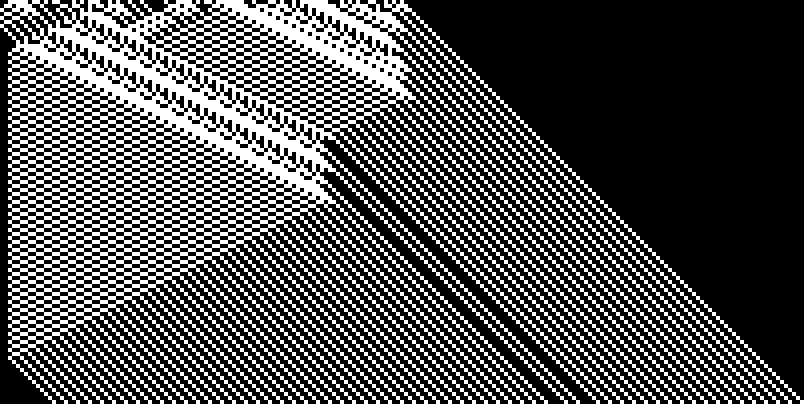

In [6]:
visualise(Plants.from_lines(data.splitlines()), 100, 4)

In [7]:
def calculate_score_at(plants, target):
    # first phase, find the stable state
    last = str(plants).strip('.')
    step = 0
    while True:
        plants.step()
        step += 1
        state = str(plants).strip('.')
        if state == last:
            break
        last = state
        
    # we can now add target - step points to the offset
    # each step the score increases by *active plants* points
    root = plants.root
    plant_count = sum(
        map(
            attrgetter("plant"),
            chain([root], root.iter_dir('right'), root.iter_dir('left'))
        )
    )
    return plants.score + (target - step) * plant_count

testplants = Plants.from_lines(testlines)
for _ in range(200):
    testplants.step()
# Can we accurately predict the score for step 200?
assert testplants.score == calculate_score_at(Plants.from_lines(testlines), 200)

In [8]:
print('Part 2:', calculate_score_at(Plants.from_lines(data.splitlines()), 50_000_000_000))

Part 2: 3100000000293
